# Data Wrangling Slot Machine Data

### 요약
이 노트북의 목적은 슬롯 머신 데이터를 만들고 정리하는 것입니다. 실제 게임 플레이 데이터를 기반으로 게임을 구현하고 Multi-armed bandit 알고리즘을 통해 가장 RTP가 높은 머신을 찾아내기 위한 프로젝트의 첫 단계입니다. 이 노트북에의 내용의 간단한 요약은 다음과 같습니다.

**게임 이미지 데이터 처리**
1. 각 슬롯머신을 플레이한 화면을 캡처한 화면을 가져옵니다.
2. 이미지를 symbol 단위로 쪼개고 저장합니다.

**훈련 데이터 정보를 담은 CSV 파일 생성**
1. 저장한 이미지 데이터의 일부를 직접 symbol별로 각 폴더에 나눠담아서 labeling 합니다.
2. 각 폴더의 데이터를 불러와서 csv파일에 저장합니다.

**각 Slot의 Symbol 분류를 위한 CNN 모델 설계**

1. 훈련 데이터를 기반으로 CNN 모델을 학습시킵니다.
2. 학습시킨 모델로 나머지 데이터(테스트 데이터)를 labeling 합니다.

**결과 값을 담을 CSV 파일 생성**
1. 예측값이 가장 높은 symbol로 labeling 합니다.
2. 그 외에 필요한 정보(game, row, column)를 추가하고 저장합니다.

# Slot - Platinum

## 1. 게임 이미지 데이터 처리

In [1]:
# 필요한 패키지 불러오기

import pandas as pd
import os
import glob
import cv2
import natsort
from os import listdir

import matplotlib.pyplot as plt
%matplotlib inline

data_path = '../data/slot_machine/'

In [2]:
# cv2 패키지로 이미지를 읽는 함수 생성

def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return img

In [3]:
# 이미지를 보여주는 함수 생성

def show_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2는 이미지 파일을 bgr로 읽기때문에 rgb로 변환
    plt.figure(figsize=(25, 12))
    plt.imshow(img)
    plt.show()

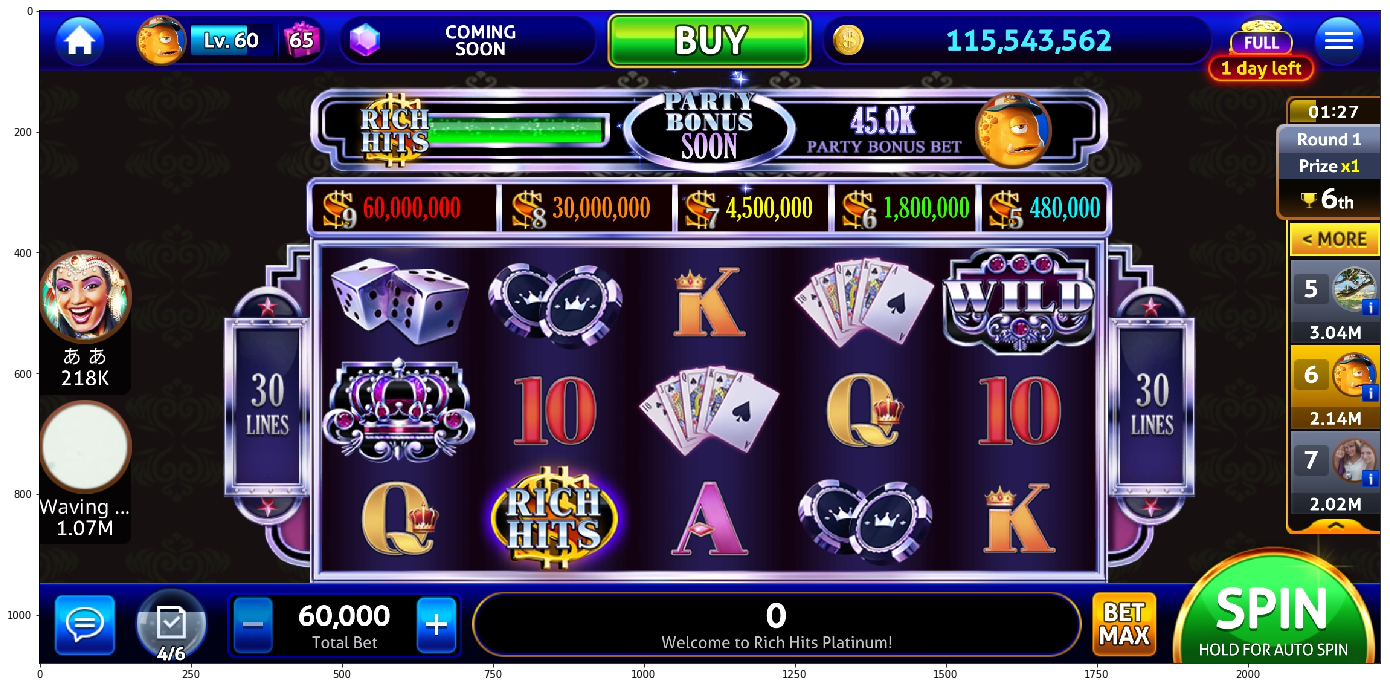

In [4]:
# 예시 이미지 불러오기

img_ex = read_image(data_path + 'platinum/platinum_1.jpg')
show_image(img_ex)

In [8]:
# 3 X 5의 슬롯 화면 외에 나머지 부분을 잘라내는 함수 생성

def platinum_trim_image(img):
    x = 470; y = 390;
    w = 1280; h = 540;
    img_trim = img[y:y+h, x:x+w]
    #cv2.imwrite('img_ex_trim.jpg', img_trim)
    return img_trim

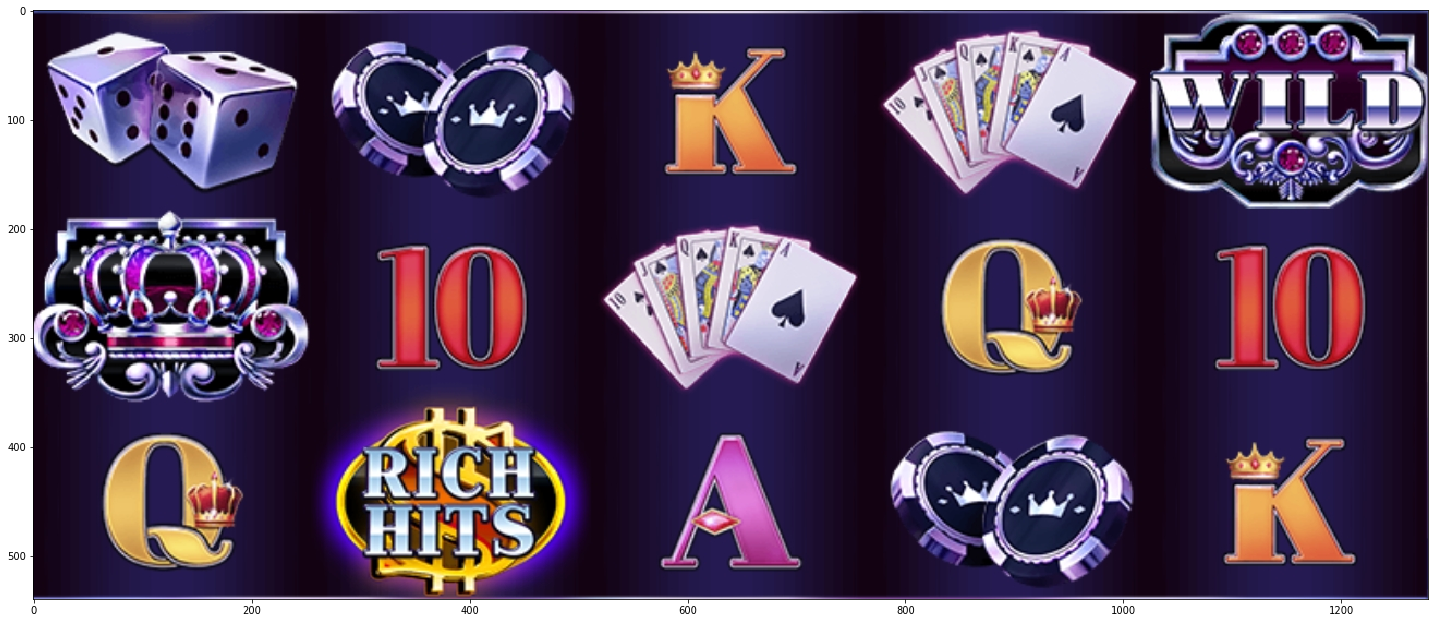

In [6]:
# 예시 이미지 자르기

img_trim = trim_image(img_ex)
show_image(img_trim)

In [4]:
# 슬롯부분 외의 이미지를 3 X 5 등분 하는 함수 생성

def platinum_image_segmentation(img, image_name, game):
    height , width, channels = img.shape # 높이, 너비, 채널 저장
    height , width = height // 3 , width // 5 # 높이는 3등분, 너비는 5등분 하기 위해 각각 3과 5로 나누기
    count = 0
    for col in range(5):
        for row in range(3):
            img_seg = img[height*row:height*(row+1), width*col:width*(col+1)]
            seg_save_path = data_path + game + '_processed'
            cv2.imwrite(os.path.join(seg_save_path, str(os.path.splitext(image_name)[0]) + '_' + str(count) + '.jpg'), img_seg)
            count += 1

In [5]:
# 생성한 이미지 처리 함수들을 이용해 이미지 가공

def platinum_image_processing(game):
    #for game in game_list:
    files = listdir(data_path + game + '/.') # 이미지 파일 불러오기
    files_sort = natsort.natsorted(files) # 숫자 오름차순으로 정렬
    for image_name in files_sort:
        img = read_image(data_path + game + '/' + image_name)
        img = platinum_trim_image(img)
        image_segmentation(img, image_name, game)

In [38]:
# 이미지 처리

platinum_image_processing('platinum')

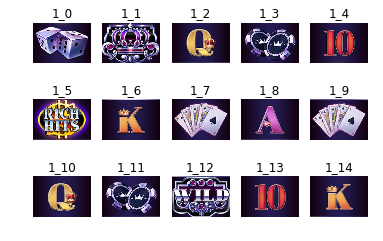

In [31]:
# 처리한 이미지 예시 시각화

for x in range(15):
    plt.subplot(3, 5, x+1)
    image = read_image(data_path + 'platinum_processed/platinum_1_{}.jpg'.format(x))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title('1_{}'.format(x))
    
plt.show()

## 2. 정보를 담은 CSV 파일 생성

In [2]:
# train 데이터를 담을 DataFrame 생성

pl_train = pd.DataFrame(columns=['img', 'classname'])

In [5]:
# 이미지를 분류해놓은 폴더 리스트 불러오기

pl_class_list = natsort.natsorted(listdir(data_path + 'platinum_train/.'))
pl_class_list

['c00_10',
 'c01_J',
 'c02_Q',
 'c03_K',
 'c04_A',
 'c05_Ca',
 'c06_Co',
 'c07_D',
 'c08_Cr',
 'c09_W',
 'c10_R']

In [6]:
# DataFrame에 데이터 파일명, class 저장

for n, c in enumerate(pl_class_list):
    names = natsort.natsorted(listdir(data_path + 'platinum_train/' + c + '/.'))
    for name in names:
        pl_train.loc[len(pl_train),:] = [name, c.split('_')[1]]

In [7]:
pl_train.head()

img classname
0   platinum_0_6.jpg        10
1   platinum_0_9.jpg        10
2  platinum_0_11.jpg        10
3  platinum_0_12.jpg        10
4   platinum_1_4.jpg        10

## 3. 각 Slot의 Symbol 분류를 위한 CNN 모델 설계

In [2]:
# 필요한 패키지 불러오기

import keras
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import shutil
import numpy as np
import subprocess
import os
from glob import glob
from datetime import datetime

C:\Users\Lee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
pl_nfolds = 2 # 교차검증 fold 수
pl_n_class = 11 # class 종류 수
pl_test_nfolds = 1 # 테스트 fold 수
pl_suffix = '.d{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S")) # 현재 년-월-일-시간-분-초 저장
pl_labels = ['c00_10', 'c01_J', 'c02_Q', 'c03_K', 'c04_A', 'c05_Ca', 'c06_Co', 'c07_D', 'c08_Cr', 'c09_W', 'c10_R'] # class 종류 리스트 생성

In [10]:
pl_temp_train_fold = data_path + 'platinum_keras/train_{}'.format(suffix) # train 데이터를 저장할 경로
pl_temp_valid_fold = data_path + 'platinum_keras/valid_{}'.format(suffix) # valid 데이터를 저장할 경로
pl_train_path = data_path + 'platinum_train' # train 데이터 경로
pl_test_path = data_path + 'platinum_test' # test 데이터 경로
print(temp_train_fold, temp_valid_fold, pl_train_path, pl_test_path)

../data/slot_machine/platinum_keras/train_.d2019-10-04-18-18-29 ../data/slot_machine/platinum_keras/valid_.d2019-10-04-18-18-29 ../data/slot_machine/platinum_train ../data/slot_machine/platinum_test


In [11]:
# 모델을 불러오는 함수 생성

def get_model():
    # vgg16 모델의 convolution 레이어로 구성된 앞부분만 불러오기
    base_model = keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(256,180,3))
    
    out = Flatten()(base_model.output)
    out = Dense(256, activation='relu')(out)
    out = Dropout(0.5)(out)
    output = Dense(11, activation='softmax')(out)
    model = Model(inputs=base_model.input, outputs=output)

    # SGD Optimizer를 사용하여, 모델을 compile한다
    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# 폴더를 비우는 함수 생성

def _clear_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

In [13]:
# train 데이터와 valid 데이터를 분리하는 함수 생성

def generate_split():
    def _generate_temp_folder(root_path):
        _clear_dir(root_path)
        for l in pl_labels:
            os.mkdir('{}/{}'.format(root_path,l))
    _generate_temp_folder(temp_train_fold)
    _generate_temp_folder(temp_valid_fold)
    
    train_samples = 0
    valid_samples = 0
    
    for label in pl_labels:
        files = glob('{}/{}/*.jpg'.format(pl_train_path, label))
        for fl in files:
            if np.random.randint(nfolds) != 1:
                shutil.copy(fl, temp_train_fold + './' + label)
                train_samples += 1
            else:
                shutil.copy(fl, temp_valid_fold + './' + label)
                valid_samples += 1
            #subprocess.call(cmd, stderr=subprocess.STDOUT, shell=True)
    print('# {} train samples | {} valid samples'.format(train_samples, valid_samples))
    return train_samples, valid_samples

In [14]:
datagen = ImageDataGenerator()

# test generator 생성
test_generator = datagen.flow_from_directory(
        directory='../data/slot_machine/platinum_test/',
        target_size=(256,180),
        batch_size=1,
        class_mode=None,
        shuffle=False)

# test 이미지 파일의 이름을 담은 리스트 생성
pl_test_id =  [os.path.basename(fl) for fl in glob('{}/imgs/*.jpg'.format(pl_test_path))]

# nfolds 수만큼 교차검증
for fold in range(nfolds):
    print('fold ', fold)
    
    model = get_model()
    
    train_samples, valid_samples = generate_split()
    
    train_generator = datagen.flow_from_directory(
                directory=temp_train_fold,
                target_size=(256,180),
                batch_size=4,
                class_mode='categorical',
                seed=2019)

    valid_generator = datagen.flow_from_directory(
                directory=temp_valid_fold,
                target_size=(256,180),
                batch_size=4,
                class_mode='categorical',
                seed=2019)
    
    #weight_path = 'cache/c{}/mini_weight.fold_{}.h5'.format(suffix,fold)
    #callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0), ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, verbose=0)]
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0)]
    
    model.fit_generator(
            train_generator,
            steps_per_epoch=train_samples/8,
            epochs=10,
            validation_data=valid_generator,
            validation_steps=valid_samples/8,
            shuffle=True,
            callbacks=callbacks,
            verbose=1)
    
    for j in range(test_nfolds):
        preds = model.predict_generator(
                    test_generator,
                    steps=len(pl_test_id),
                    verbose=1)
        
        if j == 0:
            result = pd.DataFrame(preds, columns=pl_labels)
        else:
            result += pd.DataFrame(preds, columns=pl_labels)
    
    result /= test_nfolds
    result.loc[:, 'img'] = pd.Series(pl_test_id, index=result.index)
    
    sub_file = data_path + 'platinum_result/fold{}.csv'.format(fold)
    result.to_csv(sub_file, index=False)
    
    shutil.rmtree(temp_train_fold)
    shutil.rmtree(temp_valid_fold)

Found 28940 images belonging to 1 classes.
fold  0
# 512 train samples | 538 valid samples
Found 512 images belonging to 11 classes.
Found 538 images belonging to 11 classes.
Epoch 1/10
64/64 [==============================] - 36s 563ms/step - loss: 2.0045 - acc: 0.3438 - val_loss: 1.1658 - val_acc: 0.6691
Epoch 2/10
64/64 [==============================] - 10s 161ms/step - loss: 0.9869 - acc: 0.6914 - val_loss: 0.0860 - val_acc: 1.0000
Epoch 3/10
64/64 [==============================] - 10s 158ms/step - loss: 0.2838 - acc: 0.9180 - val_loss: 0.0287 - val_acc: 1.0000
Epoch 4/10
64/64 [==============================] - 10s 158ms/step - loss: 0.1724 - acc: 0.9414 - val_loss: 0.0470 - val_acc: 0.9963
Epoch 5/10
64/64 [==============================] - 10s 158ms/step - loss: 0.0879 - acc: 0.9727 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 6/10
64/64 [==============================] - 10s 160ms/step - loss: 0.1233 - acc: 0.9727 - val_loss: 5.4355e-04 - val_acc: 1.0000
Epoch 7/10
64/64 [=====

In [15]:
#모델 저장

base_model_json = model.to_json()
with open("cnn_model/baseline_model2_{}.json".format(suffix), "w") as json_file : 
    json_file.write(base_model_json)
print("Saved model to disk")

model.save_weights("cnn_model/baseline_model2_h5_{}.h5".format(suffix))
print("Saved model to disk")

Saved model to disk
Saved model to disk


In [26]:
#단순 앙상블

ensemble = 0
for fold in range(nfolds):
    ensemble += pd.read_csv(data_path + 'platinum_result/fold{}.csv'.format(fold), index_col=-1).values * 1. / nfolds
ensemble = pd.DataFrame(ensemble, columns=pl_labels)
ensemble.loc[:, 'img'] = pd.Series(pl_test_id, index=ensemble.index)
pl_result_file = data_path + 'platinum_result/final_{}.csv'.format(suffix)
ensemble.to_csv(pl_result_file, index=False) # 결과 파일 저장

## 4. 결과 값을 담을 CSV 파일 생성

In [28]:
# 저장한 파일 불러오기

pl_final_result = pd.read_csv(pl_result_file)
pl_final_result.head()

c00_10         c01_J         c02_Q         c03_K         c04_A  \
0  1.708090e-06  9.999811e-01  7.002358e-07  7.370569e-06  3.509663e-06   
1  1.780770e-05  9.990235e-01  1.094720e-05  2.038293e-04  5.634361e-05   
2  2.030801e-05  9.991122e-01  7.319111e-06  2.223263e-04  6.720573e-05   
3  7.285592e-07  9.999824e-01  6.027867e-07  8.285221e-06  3.734715e-06   
4  1.062155e-09  2.670299e-11  1.000000e+00  3.169373e-09  3.151265e-09   

         c05_Ca        c06_Co         c07_D        c08_Cr         c09_W  \
0  2.109906e-06  2.326762e-07  4.022479e-07  7.432607e-07  1.230093e-06   
1  2.423906e-04  5.065858e-05  5.475426e-05  1.451998e-04  1.638081e-04   
2  1.302525e-04  4.245934e-05  4.205390e-05  1.681005e-04  1.557177e-04   
3  1.670240e-06  2.281047e-07  5.937737e-07  4.473158e-07  7.125428e-07   
4  5.546697e-10  1.634527e-13  1.169837e-08  2.809057e-13  6.018312e-16   

          c10_R                   img  
0  7.531207e-07   platinum_1000_0.jpg  
1  3.076142e-05   platinum_1000_1.jpg  
2  3.212447e-05  platinum_1000_10.jpg  
3  5.776201e-07  platinum_1000_11.jpg  
4  6.226446e-09  platinum_1000_12.jpg

In [29]:
# 파일 이름 숫자 오름차순으로 정렬

pl_final_result['img'] = pd.Categorical(pl_final_result['img'], ordered=True, categories=natsort.natsorted(pl_final_result['img']))
pl_final_result = pl_final_result.sort_values('img')
pl_final_result.reset_index(drop=True).head()

c00_10         c01_J         c02_Q         c03_K         c04_A  \
0  5.377807e-10  1.071034e-09  5.307387e-11  1.020953e-10  6.721215e-09   
1  1.386995e-09  7.779626e-09  1.822739e-08  1.670404e-06  9.999982e-01   
2  1.210340e-11  1.927109e-10  1.528005e-10  1.465242e-14  1.155200e-09   
3  9.146446e-07  9.999845e-01  5.324060e-07  6.568783e-06  3.206230e-06   
4  2.865769e-10  7.459139e-12  1.000000e+00  1.772413e-09  1.933054e-09   

         c05_Ca        c06_Co         c07_D        c08_Cr         c09_W  \
0  5.892797e-07  9.999991e-01  1.935057e-10  3.776017e-11  3.089846e-07   
1  4.684379e-11  6.414271e-09  1.310466e-09  4.669320e-10  7.842902e-10   
2  5.464158e-08  9.661211e-10  9.999999e-01  3.519447e-11  2.984766e-10   
3  2.160082e-06  2.109992e-07  5.691702e-07  3.363518e-07  4.503389e-07   
4  6.537788e-10  2.061965e-13  8.907513e-09  1.223787e-13  5.709115e-16   

          c10_R                img  
0  2.548309e-09  platinum_70_0.jpg  
1  5.634626e-09  platinum_70_1.jpg  
2  2.252184e-09  platinum_70_2.jpg  
3  5.991694e-07  platinum_70_3.jpg  
4  2.860337e-09  platinum_70_4.jpg

In [30]:
# 예측값이 가장 높은 class로 labeling

length = len(pl_final_result[:])
pl_class_name = [0]*length

for x in range(length):
    maxv = pl_final_result.iloc[x:x+1,0:11].values.max()
    if maxv == final_result.iloc[x:x+1,0].values:
        pl_class_name[x] = '10'
    elif maxv == pl_final_result.iloc[x:x+1,1].values:
        pl_class_name[x] = 'J'
    elif maxv == pl_final_result.iloc[x:x+1,2].values:
        pl_class_name[x] = 'Q'
    elif maxv == pl_final_result.iloc[x:x+1,3].values:
        pl_class_name[x] = 'K'
    elif maxv == pl_final_result.iloc[x:x+1,4].values:
        pl_class_name[x] = 'A'
    elif maxv == pl_final_result.iloc[x:x+1,5].values:
        pl_class_name[x] = 'Ca'
    elif maxv == pl_final_result.iloc[x:x+1,6].values:
        pl_class_name[x] = 'Co'
    elif maxv == pl_final_result.iloc[x:x+1,7].values:
        pl_class_name[x] = 'D'
    elif maxv == pl_final_result.iloc[x:x+1,8].values:
        pl_class_name[x] = 'Cr'
    elif maxv == pl_final_result.iloc[x:x+1,9].values:
        pl_class_name[x] = 'W'
    else:
        pl_class_name[x] = 'R'

In [32]:
# test 결과를 담을 DataFrame 생성

pl_test = pd.DataFrame(columns=['img', 'classname'])

In [33]:
# 예측 class 저장

pl_test['img'] = pl_final_result['img']
pl_test['classname'] = pd.Series(pl_class_name)

In [34]:
pl_test.head()

img classname
24140  platinum_70_0.jpg         A
24141  platinum_70_1.jpg         A
24147  platinum_70_2.jpg         A
24148  platinum_70_3.jpg         A
24149  platinum_70_4.jpg         W

In [35]:
# train으로 쓰인 데이터와 test 결과를 병합

pl_all = pd.concat([pl_train, pl_test])
pl_all.head()

img classname
0   platinum_0_6.jpg        10
1   platinum_0_9.jpg        10
2  platinum_0_11.jpg        10
3  platinum_0_12.jpg        10
4   platinum_1_4.jpg        10

In [38]:
# 파일 이름으로 정렬

pl_all['img'] = pd.Categorical(pl_all['img'], ordered=True, categories=natsort.natsorted(pl_all['img']))
pl_all = pl_all.sort_values('img')
pl_all.reset_index(drop=True, inplace=True)
pl_all.head()

img classname
0  platinum_0_0.jpg        Ca
1  platinum_0_1.jpg         A
2  platinum_0_2.jpg         Q
3  platinum_0_3.jpg         W
4  platinum_0_4.jpg         A

In [129]:
# DataFrame 저장

pl_all.to_csv(data_path + '/platinum_csv/pl_all.csv', index=False)

NameError: name 'pl_all' is not defined

# Slot - Monster

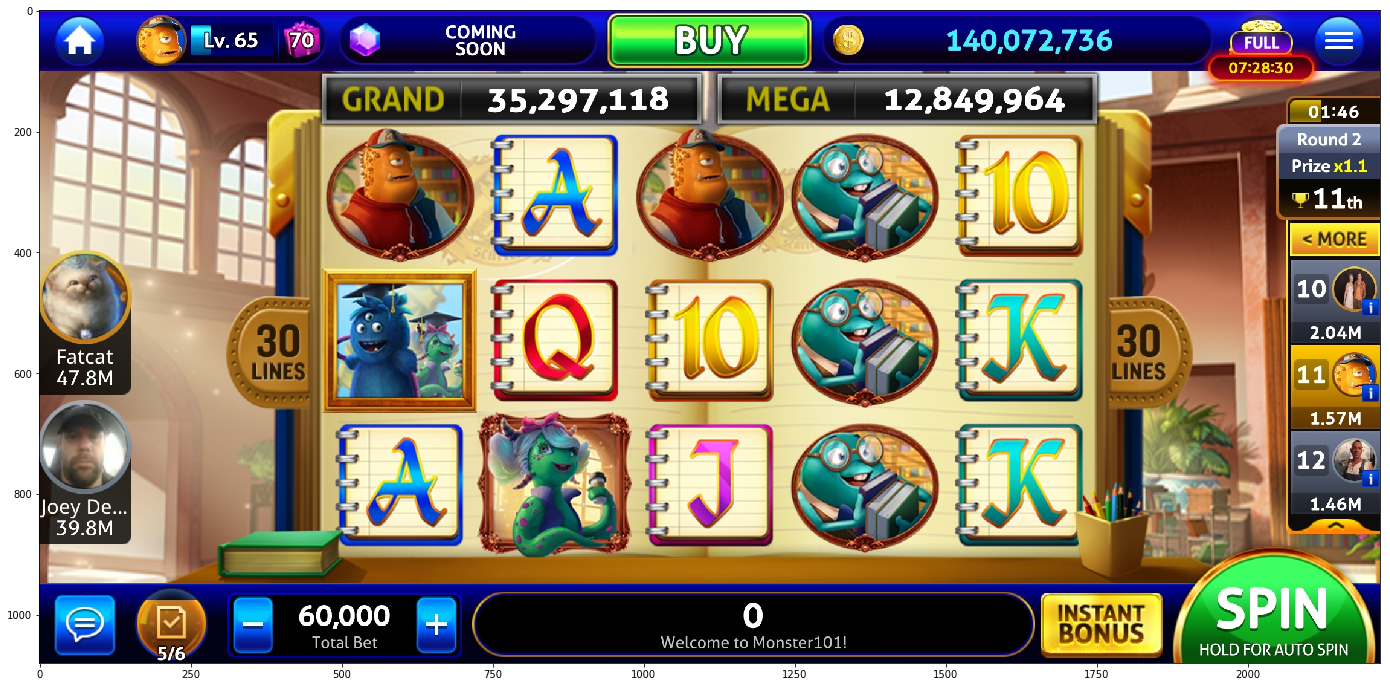

In [5]:
img_ex = read_image(data_path + 'monster/monster_0.jpg')
show_image(img_ex)

In [6]:
def monster_trim_image(img):
    x = 470; y = 190;
    w = 1280; h = 710;
    img_trim = img[y:y+h, x:x+w]
    #cv2.imwrite('img_ex_trim.jpg', img_trim)
    return img_trim

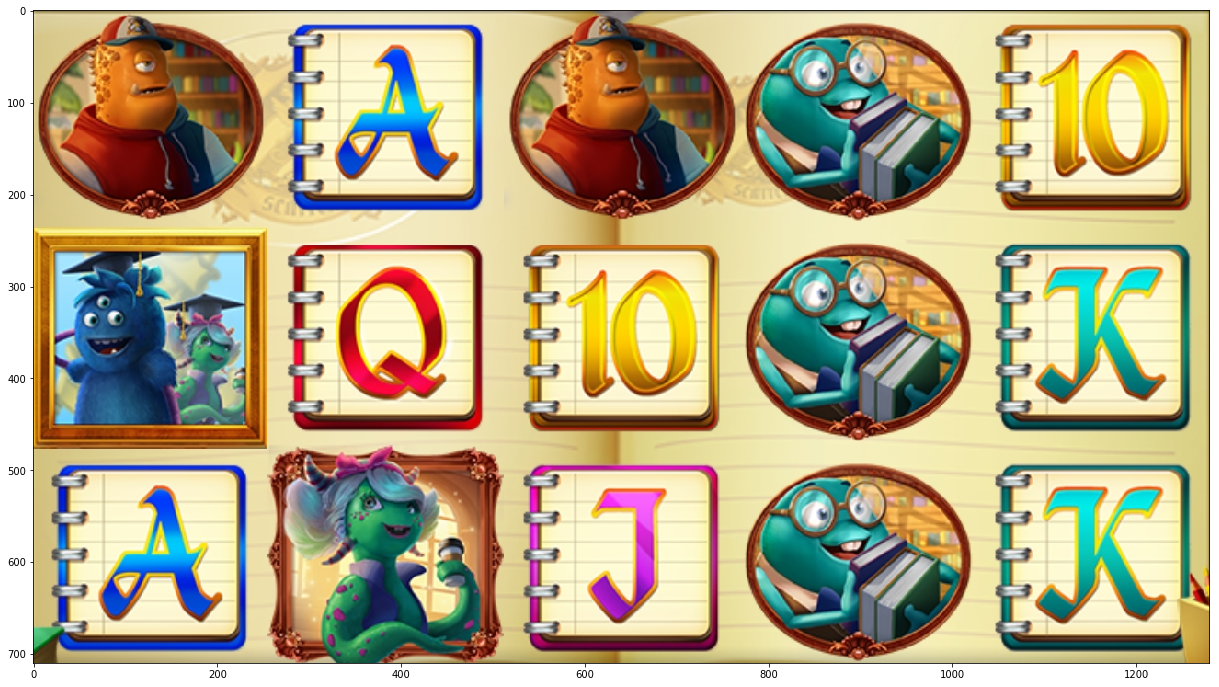

In [7]:
img_trim = monster_trim_image(img_ex)
show_image(img_trim)

In [8]:
# 슬롯부분 외의 이미지를 3 X 5 등분 하는 함수 생성

def monster_image_segmentation(img, image_name, game):
    height , width, channels = img.shape # 높이, 너비, 채널 저장
    height , width = height // 3 , width // 5 # 높이는 3등분, 너비는 5등분 하기 위해 각각 3과 5로 나누기
    count = 0
    for col in range(5):
        for row in range(3):
            img_seg = img[height*row:height*(row+1), width*col:width*(col+1)]
            seg_save_path = data_path + game + '_processed'
            cv2.imwrite(os.path.join(seg_save_path, str(os.path.splitext(image_name)[0]) + '_' + str(count) + '.jpg'), img_seg)
            count += 1

In [9]:
# 생성한 이미지 처리 함수들을 이용해 이미지 가공

def monster_image_processing(game):
    #for game in game_list:
    files = listdir(data_path + game + '/.') # 이미지 파일 불러오기
    files_sort = natsort.natsorted(files) # 숫자 오름차순으로 정렬
    for image_name in files_sort:
        img = read_image(data_path + game + '/' + image_name)
        img = monster_trim_image(img)
        monster_image_segmentation(img, image_name, game)

In [10]:
monster_image_processing('monster')

KeyboardInterrupt: 

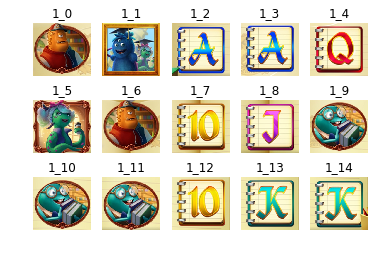

In [11]:
# 처리한 이미지 예시 시각화

for x in range(15):
    plt.subplot(3, 5, x+1)
    image = read_image(data_path + 'monster_processed/monster_0_{}.jpg'.format(x))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title('1_{}'.format(x))
    
plt.show()

In [3]:
# train 데이터를 담을 DataFrame 생성

ms_train = pd.DataFrame(columns=['img', 'classname'])

In [4]:
# 이미지를 분류해놓은 폴더 리스트 불러오기

ms_class_list = natsort.natsorted(listdir(data_path + 'monster_train/.'))
ms_class_list

['c00_10',
 'c01_J',
 'c02_Q',
 'c03_K',
 'c04_A',
 'c05_GGM',
 'c06_OM',
 'c07_RM',
 'c08_GWM',
 'c09_W',
 'c10_S']

In [5]:
# DataFrame에 데이터 파일명, class 저장

for n, c in enumerate(ms_class_list):
    names = natsort.natsorted(listdir(data_path + 'monster_train/' + c + '/.'))
    for name in names:
        ms_train.loc[len(ms_train),:] = [name, c.split('_')[1]]

In [6]:
ms_train.head()

img classname
0   monster_0_7.jpg        10
1  monster_0_12.jpg        10
2   monster_1_4.jpg        10
3  monster_1_11.jpg        10
4   monster_2_9.jpg        10

In [14]:
ms_nfolds = 3 # 교차검증 fold 수
ms_n_class = 10 # class 종류 수
ms_test_nfolds = 1 # 테스트 fold 수
ms_suffix = '.d{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S")) # 현재 년-월-일-시간-분-초 저장
ms_labels = ms_class_list

In [15]:
ms_temp_train_fold = data_path + 'monster_keras/train_{}'.format(suffix) # train 데이터를 저장할 경로
ms_temp_valid_fold = data_path + 'monster_keras/valid_{}'.format(suffix) # valid 데이터를 저장할 경로
ms_train_path = data_path + 'monster_train' # train 데이터 경로
ms_test_path = data_path + 'monster_test' # test 데이터 경로
print(ms_temp_train_fold, ms_temp_valid_fold, ms_train_path, ms_test_path)

../data/slot_machine/monster_keras/train_.d2019-10-25-17-55-26 ../data/slot_machine/monster_keras/valid_.d2019-10-25-17-55-26 ../data/slot_machine/monster_train ../data/slot_machine/monster_test


In [16]:
# 모델을 불러오는 함수 생성

def get_monster_model():
    # vgg16 모델의 convolution 레이어로 구성된 앞부분만 불러오기
    base_model = keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(256,236,3))
    
    out = Flatten()(base_model.output)
    out = Dense(256, activation='relu')(out)
    out = Dropout(0.5)(out)
    output = Dense(11, activation='softmax')(out)
    model = Model(inputs=base_model.input, outputs=output)

    # SGD Optimizer를 사용하여, 모델을 compile한다
    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# 폴더를 비우는 함수 생성

def _clear_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

In [18]:
# train 데이터와 valid 데이터를 분리하는 함수 생성

def generate_split():
    def _generate_temp_folder(root_path):
        _clear_dir(root_path)
        for l in ms_labels:
            os.mkdir('{}/{}'.format(root_path,l))
    _generate_temp_folder(temp_train_fold)
    _generate_temp_folder(temp_valid_fold)
    
    train_samples = 0
    valid_samples = 0
    
    for label in ms_labels:
        files = glob('{}/{}/*.jpg'.format(ms_train_path, label))
        for fl in files:
            if np.random.randint(nfolds) != 1:
                shutil.copy(fl, temp_train_fold + './' + label)
                train_samples += 1
            else:
                shutil.copy(fl, temp_valid_fold + './' + label)
                valid_samples += 1
            #subprocess.call(cmd, stderr=subprocess.STDOUT, shell=True)
    print('# {} train samples | {} valid samples'.format(train_samples, valid_samples))
    return train_samples, valid_samples

In [22]:
datagen = ImageDataGenerator()

# test generator 생성
test_generator = datagen.flow_from_directory(
        directory='../data/slot_machine/monster_test/',
        target_size=(256,236),
        batch_size=1,
        class_mode=None,
        shuffle=False)

# test 이미지 파일의 이름을 담은 리스트 생성
ms_test_id =  [os.path.basename(fl) for fl in glob('{}/imgs/*.jpg'.format(ms_test_path))]

# nfolds 수만큼 교차검증
for fold in range(nfolds):
    print('fold ', fold)
    
    model = get_monster_model()
    
    train_samples, valid_samples = generate_split()
    
    train_generator = datagen.flow_from_directory(
                directory=temp_train_fold,
                target_size=(256,236),
                batch_size=4,
                class_mode='categorical',
                seed=2019)

    valid_generator = datagen.flow_from_directory(
                directory=temp_valid_fold,
                target_size=(256,236),
                batch_size=4,
                class_mode='categorical',
                seed=2019)
    
    #weight_path = 'cache/c{}/mini_weight.fold_{}.h5'.format(suffix,fold)
    #callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0), ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, verbose=0)]
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0)]
    
    model.fit_generator(
            train_generator,
            steps_per_epoch=train_samples/8,
            epochs=10,
            validation_data=valid_generator,
            validation_steps=valid_samples/8,
            shuffle=True,
            callbacks=callbacks,
            verbose=1)
    
    for j in range(test_nfolds):
        preds = model.predict_generator(
                    test_generator,
                    steps=len(ms_test_id),
                    verbose=1)
        
        if j == 0:
            ms_result = pd.DataFrame(preds, columns=ms_labels)
        else:
            ms_result += pd.DataFrame(preds, columns=ms_labels)
    
    ms_result /= test_nfolds
    ms_result.loc[:, 'img'] = pd.Series(ms_test_id, index=ms_result.index)
    
    sub_file = data_path + 'monster_result/fold{}.csv'.format(fold)
    ms_result.to_csv(sub_file, index=False)
    
    shutil.rmtree(ms_temp_train_fold)
    shutil.rmtree(ms_temp_valid_fold)

Found 28917 images belonging to 1 classes.
fold  0
# 721 train samples | 361 valid samples
Found 721 images belonging to 11 classes.
Found 361 images belonging to 11 classes.
Epoch 1/10
41/90 [============>.................] - ETA: 11s - loss: 2.2997 - acc: 0.2561

KeyboardInterrupt: 

In [114]:
#모델 저장

base_model_json = model.to_json()
with open("cnn_model/monster_model_{}.json".format(suffix), "w") as json_file : 
    json_file.write(base_model_json)
print("Saved model to disk")

model.save_weights("cnn_model/monster_model_h5_{}.h5".format(suffix))
print("Saved model to disk")

Saved model to disk
Saved model to disk


In [122]:
#단순 앙상블

ensemble = 0
for fold in range(nfolds):
    ensemble += pd.read_csv(data_path + 'monster_result/fold{}.csv'.format(fold), index_col=-1).values * 1. / nfolds
ensemble = pd.DataFrame(ensemble, columns=labels)
ensemble.loc[:, 'img'] = pd.Series(ms_test_id, index=ensemble.index)
ms_result_file = data_path + 'monster_result/final_{}.csv'.format(suffix)
ensemble.to_csv(ms_result_file, index=False) # 결과 파일 저장

In [123]:
ms_final_result = pd.read_csv(ms_result_file)
ms_final_result.head()

c00_10         c01_J     c02_Q         c03_K         c04_A  \
0  6.575556e-06  7.772561e-08  0.000002  3.782762e-07  3.216641e-07   
1  9.999579e-01  4.125700e-09  0.000011  5.428013e-10  4.002474e-09   
2  2.158950e-07  2.323658e-05  0.000024  1.693695e-04  9.997829e-01   
3  2.538517e-07  2.410820e-05  0.000027  2.620075e-04  9.996858e-01   
4  5.657561e-06  6.085507e-08  0.000002  3.729898e-07  2.806504e-07   

        c05_GGM        c06_OM        c07_RM       c08_GWM         c09_W  \
0  9.999895e-01  8.946020e-08  3.772183e-07  1.485865e-07  2.426891e-07   
1  1.328315e-09  3.042547e-05  1.182778e-08  1.440333e-08  8.454511e-09   
2  1.197200e-07  2.734728e-08  5.967612e-09  1.383248e-07  1.084206e-08   
3  1.133696e-07  2.671587e-08  7.944902e-09  1.333392e-07  1.435187e-08   
4  9.999905e-01  1.471690e-07  5.318126e-07  1.116119e-07  1.544840e-07   

          c10_S                  img  
0  5.139453e-07   monster_1000_0.jpg  
1  8.459302e-07   monster_1000_1.jpg  
2  3.193385e-07  monster_1000_10.jpg  
3  3.105264e-07  monster_1000_11.jpg  
4  4.010275e-07  monster_1000_12.jpg

In [124]:
ms_final_result['img'] = pd.Categorical(ms_final_result['img'], ordered=True, categories=natsort.natsorted(ms_final_result['img']))
ms_final_result = ms_final_result.sort_values('img')
ms_final_result = ms_final_result.reset_index(drop=True)
ms_final_result.head()

c00_10         c01_J         c02_Q         c03_K         c04_A  \
0  5.592876e-05  1.136504e-05  6.539951e-05  8.797074e-06  9.215684e-05   
1  5.905573e-05  1.163852e-05  5.885221e-05  8.770992e-06  9.851837e-05   
2  6.168786e-05  1.742058e-05  7.184366e-05  8.449963e-06  7.455450e-05   
3  6.312979e-06  6.502984e-08  2.256658e-06  3.734769e-07  3.285527e-07   
4  2.380388e-07  3.213896e-07  1.843021e-07  9.999938e-01  5.524298e-06   

        c05_GGM        c06_OM        c07_RM       c08_GWM         c09_W  \
0  1.736840e-05  1.155768e-02  9.873717e-01  1.967229e-04  3.375017e-04   
1  1.970668e-05  1.306390e-02  9.859337e-01  1.682419e-04  3.967269e-04   
2  1.738395e-05  1.398699e-02  9.849986e-01  2.072890e-04  3.743333e-04   
3  9.999896e-01  1.804637e-07  4.019520e-07  9.813129e-08  1.296439e-07   
4  9.423052e-09  4.699444e-09  2.831156e-09  1.099301e-08  1.169918e-09   

          c10_S               img  
0  2.852719e-04  monster_70_0.jpg  
1  1.810347e-04  monster_70_1.jpg  
2  1.814605e-04  monster_70_2.jpg  
3  3.601137e-07  monster_70_3.jpg  
4  1.657773e-08  monster_70_4.jpg

In [125]:
# 예측값이 가장 높은 class로 labeling

length = len(ms_final_result[:])
ms_class_name = [0]*length

for x in range(length):
    maxv = ms_final_result.iloc[x:x+1,0:11].values.max()
    if maxv == ms_final_result.iloc[x:x+1,0].values:
        ms_class_name[x] = '10'
    elif maxv == ms_final_result.iloc[x:x+1,1].values:
        ms_class_name[x] = 'J'
    elif maxv == ms_final_result.iloc[x:x+1,2].values:
        ms_class_name[x] = 'Q'
    elif maxv == ms_final_result.iloc[x:x+1,3].values:
        ms_class_name[x] = 'K'
    elif maxv == ms_final_result.iloc[x:x+1,4].values:
        ms_class_name[x] = 'A'
    elif maxv == ms_final_result.iloc[x:x+1,5].values:
        ms_class_name[x] = 'GGM'
    elif maxv == ms_final_result.iloc[x:x+1,6].values:
        ms_class_name[x] = 'OM'
    elif maxv == ms_final_result.iloc[x:x+1,7].values:
        ms_class_name[x] = 'RM'
    elif maxv == ms_final_result.iloc[x:x+1,8].values:
        ms_class_name[x] = 'GWM'
    elif maxv == ms_final_result.iloc[x:x+1,9].values:
        ms_class_name[x] = 'W'
    else:
        ms_class_name[x] = 'S'

In [126]:
# test 결과를 담을 DataFrame 생성

ms_test = pd.DataFrame(columns=['img', 'classname'])

ms_test['img'] = ms_final_result['img']
ms_test['classname'] = pd.Series(ms_class_name)

ms_test.head()

img classname
0  monster_70_0.jpg        RM
1  monster_70_1.jpg        RM
2  monster_70_2.jpg        RM
3  monster_70_3.jpg       GGM
4  monster_70_4.jpg         K

In [127]:
# train으로 쓰인 데이터와 test 결과를 병합

ms_all = pd.concat([ms_train, ms_test])
ms_all.head()

img classname
0  monster_0_0.jpg        OM
1  monster_0_1.jpg         W
2  monster_0_2.jpg         A
3  monster_0_3.jpg         A
4  monster_0_4.jpg         Q

In [128]:
# DataFrame 저장

ms_all.to_csv(data_path + '/monster_csv/ms_all.csv', index=False)

# Slot - Masquerade

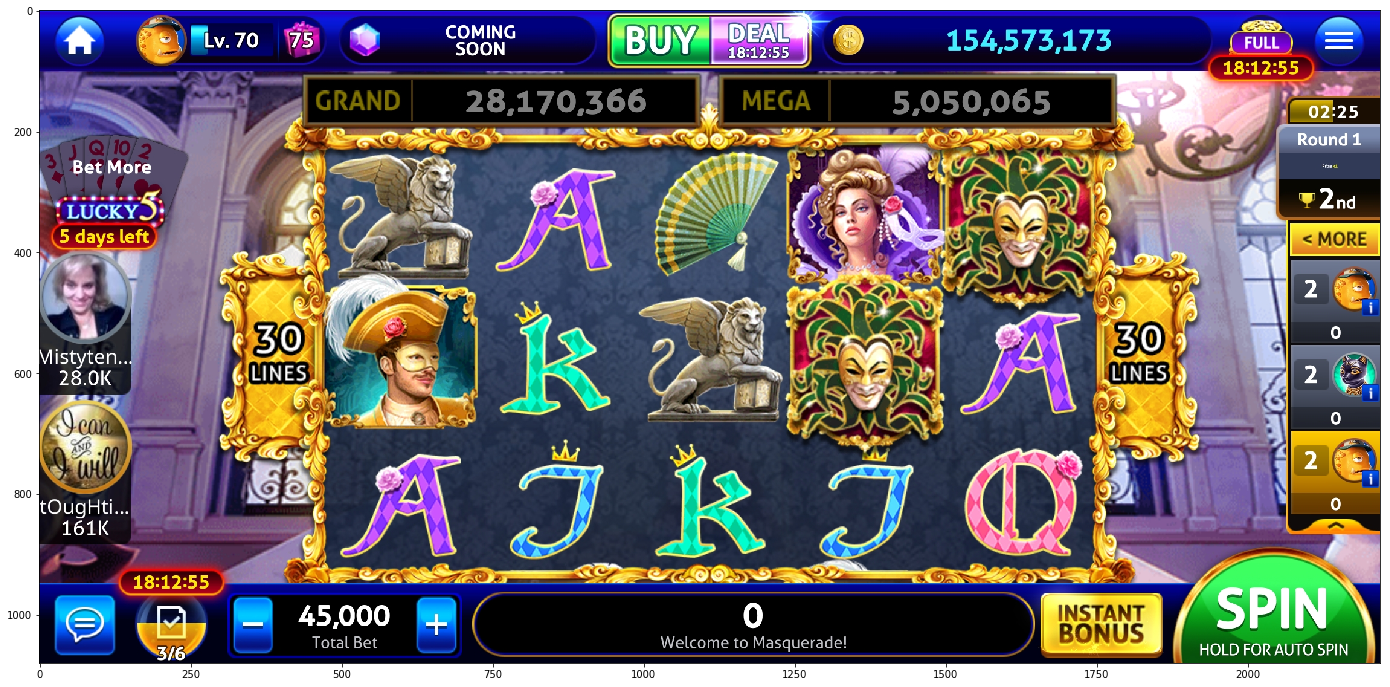

In [5]:
img_ex = read_image(data_path + 'masque/masque_0.jpg')
show_image(img_ex)

In [4]:
def masque_trim_image(img):
    x = 470; y = 230;
    w = 1280; h = 690;
    img_trim = img[y:y+h, x:x+w]
    #cv2.imwrite('img_ex_trim.jpg', img_trim)
    return img_trim

In [5]:
img_trim = monster_trim_image(img_ex)
show_image(img_trim)

NameError: name 'monster_trim_image' is not defined

In [6]:
# 슬롯부분 외의 이미지를 3 X 5 등분 하는 함수 생성

def masque_image_segmentation(img, image_name, game):
    height , width, channels = img.shape # 높이, 너비, 채널 저장
    height , width = height // 3 , width // 5 # 높이는 3등분, 너비는 5등분 하기 위해 각각 3과 5로 나누기
    count = 0
    for col in range(5):
        for row in range(3):
            img_seg = img[height*row:height*(row+1), width*col:width*(col+1)]
            seg_save_path = data_path + game + '_processed'
            cv2.imwrite(os.path.join(seg_save_path, str(os.path.splitext(image_name)[0]) + '_' + str(count) + '.jpg'), img_seg)
            count += 1

In [21]:
# 생성한 이미지 처리 함수들을 이용해 이미지 가공

def masque_image_processing(game):
    #for game in game_list:
    files = listdir(data_path + game + '/.') # 이미지 파일 불러오기
    files_sort = natsort.natsorted(files) # 숫자 오름차순으로 정렬
    for image_name in files_sort:
        img = read_image(data_path + game + '/' + image_name)
        img = masque_trim_image(img)
        masque_image_segmentation(img, image_name, game)

In [25]:
masque_image_processing('masque')

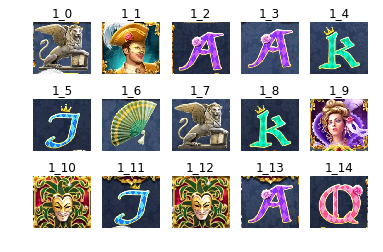

In [26]:
# 처리한 이미지 예시 시각화

for x in range(15):
    plt.subplot(3, 5, x+1)
    image = read_image(data_path + 'masque_processed/masque_0_{}.jpg'.format(x))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title('1_{}'.format(x))
    
plt.show()

In [27]:
# train 데이터를 담을 DataFrame 생성

mq_train = pd.DataFrame(columns=['img', 'classname'])

In [28]:
# 이미지를 분류해놓은 폴더 리스트 불러오기

mq_class_list = natsort.natsorted(listdir(data_path + 'masque_train/.'))
mq_class_list

['c00_J',
 'c01_Q',
 'c02_K',
 'c03_A',
 'c04_F',
 'c05_H',
 'c06_Ms',
 'c07_St',
 'c08_Mn',
 'c09_Wm',
 'c10_Sc',
 'c11_W']

In [29]:
# DataFrame에 데이터 파일명, class 저장

for n, c in enumerate(mq_class_list):
    names = natsort.natsorted(listdir(data_path + 'masque_train/' + c + '/.'))
    for name in names:
        mq_train.loc[len(mq_train),:] = [name, c.split('_')[1]]

In [31]:
mq_train.head()

img classname
0   masque_0_5.jpg         J
1  masque_0_11.jpg         J
2  masque_1_10.jpg         J
3  masque_1_12.jpg         J
4  masque_1_14.jpg         J

In [34]:
nfolds = 2 # 교차검증 fold 수
n_class = 11 # class 종류 수
test_nfolds = 1 # 테스트 fold 수
suffix = '.d{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S")) # 현재 년-월-일-시간-분-초 저장
labels = mq_class_list

In [35]:
temp_train_fold = data_path + 'masque_keras/train_{}'.format(suffix) # train 데이터를 저장할 경로
temp_valid_fold = data_path + 'masque_keras/valid_{}'.format(suffix) # valid 데이터를 저장할 경로
mq_train_path = data_path + 'masque_train' # train 데이터 경로
mq_test_path = data_path + 'masque_test' # test 데이터 경로
print(temp_train_fold, temp_valid_fold, mq_train_path, mq_test_path)

../data/slot_machine/masque_keras/train_.d2019-10-17-19-01-59 ../data/slot_machine/masque_keras/valid_.d2019-10-17-19-01-59 ../data/slot_machine/masque_train ../data/slot_machine/masque_test


In [36]:
# 모델을 불러오는 함수 생성

def get_masque_model():
    # vgg16 모델의 convolution 레이어로 구성된 앞부분만 불러오기
    base_model = keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(256,230,3))
    
    out = Flatten()(base_model.output)
    out = Dense(256, activation='relu')(out)
    out = Dropout(0.5)(out)
    output = Dense(12, activation='softmax')(out)
    model = Model(inputs=base_model.input, outputs=output)

    # SGD Optimizer를 사용하여, 모델을 compile한다
    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [37]:
# 폴더를 비우는 함수 생성

def _clear_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

In [38]:
# train 데이터와 valid 데이터를 분리하는 함수 생성

def generate_split():
    def _generate_temp_folder(root_path):
        _clear_dir(root_path)
        for l in labels:
            os.mkdir('{}/{}'.format(root_path,l))
    _generate_temp_folder(temp_train_fold)
    _generate_temp_folder(temp_valid_fold)
    
    train_samples = 0
    valid_samples = 0
    
    for label in labels:
        files = glob('{}/{}/*.jpg'.format(mq_train_path, label))
        for fl in files:
            if np.random.randint(nfolds) != 1:
                shutil.copy(fl, temp_train_fold + './' + label)
                train_samples += 1
            else:
                shutil.copy(fl, temp_valid_fold + './' + label)
                valid_samples += 1
            #subprocess.call(cmd, stderr=subprocess.STDOUT, shell=True)
    print('# {} train samples | {} valid samples'.format(train_samples, valid_samples))
    return train_samples, valid_samples

In [44]:
datagen = ImageDataGenerator()

# test generator 생성
test_generator = datagen.flow_from_directory(
        directory='../data/slot_machine/masque_test/',
        target_size=(256,230),
        batch_size=1,
        class_mode=None,
        shuffle=False)

# test 이미지 파일의 이름을 담은 리스트 생성
mq_test_id =  [os.path.basename(fl) for fl in glob('{}/imgs/*.jpg'.format(mq_test_path))]

# nfolds 수만큼 교차검증
for fold in range(nfolds):
    print('fold ', fold)
    
    model = get_masque_model()
    
    train_samples, valid_samples = generate_split()
    
    train_generator = datagen.flow_from_directory(
                directory=temp_train_fold,
                target_size=(256,230),
                batch_size=4,
                class_mode='categorical',
                seed=2019)

    valid_generator = datagen.flow_from_directory(
                directory=temp_valid_fold,
                target_size=(256,230),
                batch_size=4,
                class_mode='categorical',
                seed=2019)
    
    #weight_path = 'cache/c{}/mini_weight.fold_{}.h5'.format(suffix,fold)
    #callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0), ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, verbose=0)]
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0)]
    
    model.fit_generator(
            train_generator,
            steps_per_epoch=train_samples/8,
            epochs=10,
            validation_data=valid_generator,
            validation_steps=valid_samples/8,
            shuffle=True,
            callbacks=callbacks,
            verbose=1)
    
    for j in range(test_nfolds):
        preds = model.predict_generator(
                    test_generator,
                    steps=len(mq_test_id),
                    verbose=1)
        
        if j == 0:
            result = pd.DataFrame(preds, columns=labels)
        else:
            result += pd.DataFrame(preds, columns=labels)
    
    result /= test_nfolds
    result.loc[:, 'img'] = pd.Series(mq_test_id, index=result.index)
    
    sub_file = data_path + 'masque_result/fold{}.csv'.format(fold)
    result.to_csv(sub_file, index=False)
    
    shutil.rmtree(temp_train_fold)
    shutil.rmtree(temp_valid_fold)

Found 28950 images belonging to 1 classes.
fold  0
# 534 train samples | 516 valid samples
Found 534 images belonging to 12 classes.
Found 516 images belonging to 12 classes.
Epoch 1/10
67/66 [==============================] - 14s 215ms/step - loss: 2.0543 - acc: 0.3358 - val_loss: 1.1739 - val_acc: 0.6000
Epoch 2/10
67/66 [==============================] - 12s 176ms/step - loss: 0.8865 - acc: 0.7500 - val_loss: 0.1144 - val_acc: 0.9769
Epoch 3/10
67/66 [==============================] - 12s 174ms/step - loss: 0.4407 - acc: 0.8732 - val_loss: 0.1429 - val_acc: 0.9962
Epoch 4/10
67/66 [==============================] - 12s 176ms/step - loss: 0.1314 - acc: 0.9664 - val_loss: 0.0448 - val_acc: 0.9885
Epoch 5/10
67/66 [==============================] - 12s 177ms/step - loss: 0.1118 - acc: 0.9590 - val_loss: 0.0099 - val_acc: 0.9962
Epoch 6/10
67/66 [==============================] - 12s 177ms/step - loss: 0.0159 - acc: 0.9963 - val_loss: 2.0113e-04 - val_acc: 1.0000
Epoch 7/10
67/66 [=====

In [45]:
#모델 저장

base_model_json = model.to_json()
with open("cnn_model/masque_model_{}.json".format(suffix), "w") as json_file : 
    json_file.write(base_model_json)
print("Saved model to disk")

model.save_weights("cnn_model/masque_model_h5_{}.h5".format(suffix))
print("Saved model to disk")

Saved model to disk
Saved model to disk


In [46]:
#단순 앙상블

ensemble = 0
for fold in range(nfolds):
    ensemble += pd.read_csv(data_path + 'masque_result/fold{}.csv'.format(fold), index_col=-1).values * 1. / nfolds
ensemble = pd.DataFrame(ensemble, columns=labels)
ensemble.loc[:, 'img'] = pd.Series(mq_test_id, index=ensemble.index)
result_file = data_path + 'masque_result/final_{}.csv'.format(suffix)
ensemble.to_csv(result_file, index=False) # 결과 파일 저장

In [47]:
final_result = pd.read_csv(result_file)
final_result.head()

c00_J         c01_Q         c02_K         c03_A         c04_F  \
0  3.152441e-07  1.445944e-04  2.486352e-08  8.961929e-09  9.998541e-01   
1  1.135057e-06  1.062020e-04  4.216561e-08  3.816061e-08  9.998915e-01   
2  2.510234e-07  6.718741e-05  1.187911e-08  4.209097e-08  9.999319e-01   
3  9.999864e-01  2.782798e-07  4.003126e-07  6.112147e-06  7.648812e-07   
4  6.870055e-06  7.722845e-04  1.268939e-05  1.154145e-05  1.394381e-05   

          c05_H        c06_Ms        c07_St        c08_Mn        c09_Wm  \
0  4.063831e-07  2.315174e-07  2.532122e-07  5.280737e-08  3.168286e-08   
1  3.774608e-07  4.583601e-07  1.874910e-07  5.915786e-08  3.215021e-08   
2  4.355135e-07  1.390320e-07  1.392556e-07  1.190056e-08  7.623219e-09   
3  1.066196e-07  5.622822e-06  3.258546e-09  2.414664e-07  1.716090e-08   
4  4.634853e-06  9.990322e-01  1.114384e-05  2.202222e-07  9.767552e-07   

         c10_Sc         c11_W                 img  
0  2.949277e-09  2.652307e-09   masque_1000_0.jpg  
1  4.067110e-09  1.759087e-09   masque_1000_1.jpg  
2  1.758967e-09  1.442948e-09  masque_1000_10.jpg  
3  2.700848e-08  1.756223e-08  masque_1000_11.jpg  
4  1.462421e-06  1.321224e-04  masque_1000_12.jpg

In [48]:
final_result['img'] = pd.Categorical(final_result['img'], ordered=True, categories=natsort.natsorted(final_result['img']))
final_result = final_result.sort_values('img')
final_result = final_result.reset_index(drop=True)
final_result.head()

c00_J         c01_Q         c02_K         c03_A         c04_F  \
0  2.479375e-08  2.158930e-05  7.561784e-10  6.024206e-08  1.375303e-06   
1  9.999785e-01  6.645525e-07  6.548426e-07  5.470230e-06  9.112387e-07   
2  7.218531e-07  1.013915e-04  1.660200e-08  2.434994e-07  9.998961e-01   
3  2.132451e-08  2.136253e-05  6.129771e-10  5.252865e-08  1.128803e-06   
4  4.990852e-06  1.433297e-03  1.292451e-05  1.095083e-05  1.089844e-05   

          c05_H        c06_Ms        c07_St        c08_Mn        c09_Wm  \
0  9.999751e-01  1.903878e-07  2.506474e-09  1.195488e-09  9.219891e-07   
1  3.769444e-07  1.284369e-05  9.791871e-09  3.537980e-07  4.988831e-08   
2  9.566606e-07  2.775269e-07  2.183965e-07  1.032829e-08  1.133097e-08   
3  9.999756e-01  1.601590e-07  2.148174e-09  9.872371e-10  8.158183e-07   
4  2.138491e-06  9.984106e-01  5.177855e-06  1.415182e-07  6.173596e-07   

         c10_Sc         c11_W              img  
0  7.507230e-07  6.636778e-11  masque_70_0.jpg  
1  4.712285e-08  5.320088e-08  masque_70_1.jpg  
2  6.764658e-09  1.869868e-09  masque_70_2.jpg  
3  8.264025e-07  5.707340e-11  masque_70_3.jpg  
4  7.115959e-07  1.075930e-04  masque_70_4.jpg

In [49]:
# 예측값이 가장 높은 class로 labeling

length = len(final_result[:])
mq_class_name = [0]*length

for x in range(length):
    maxv = final_result.iloc[x:x+1,0:12].values.max()
    if maxv == final_result.iloc[x:x+1,0].values:
        mq_class_name[x] = 'J'
    elif maxv == final_result.iloc[x:x+1,1].values:
        mq_class_name[x] = 'Q'
    elif maxv == final_result.iloc[x:x+1,2].values:
        mq_class_name[x] = 'K'
    elif maxv == final_result.iloc[x:x+1,3].values:
        mq_class_name[x] = 'A'
    elif maxv == final_result.iloc[x:x+1,4].values:
        mq_class_name[x] = 'F'
    elif maxv == final_result.iloc[x:x+1,5].values:
        mq_class_name[x] = 'H'
    elif maxv == final_result.iloc[x:x+1,6].values:
        mq_class_name[x] = 'Ms'
    elif maxv == final_result.iloc[x:x+1,7].values:
        mq_class_name[x] = 'St'
    elif maxv == final_result.iloc[x:x+1,8].values:
        mq_class_name[x] = 'Mn'
    elif maxv == final_result.iloc[x:x+1,9].values:
        mq_class_name[x] = 'Wm'
    elif maxv == final_result.iloc[x:x+1,10].values:
        mq_class_name[x] = 'Sc'
    else:
        mq_class_name[x] = 'W'

In [107]:
# test 결과를 담을 DataFrame 생성

mq_test = pd.DataFrame(columns=['img', 'classname'])

mq_test['img'] = final_result['img']
mq_test['classname'] = pd.Series(mq_class_name)

mq_test.head()

img classname
0  masque_70_0.jpg        RM
1  masque_70_1.jpg        RM
2  masque_70_2.jpg        RM
3  masque_70_3.jpg       GGM
4  masque_70_4.jpg         K

In [51]:
# train으로 쓰인 데이터와 test 결과를 병합

mq_all = pd.concat([mq_train, mq_test])
mq_all.head()

img classname
0   masque_0_5.jpg         J
1  masque_0_11.jpg         J
2  masque_1_10.jpg         J
3  masque_1_12.jpg         J
4  masque_1_14.jpg         J

In [54]:
# 파일 이름으로 정렬

mq_all['img'] = pd.Categorical(mq_all['img'], ordered=True, categories=natsort.natsorted(mq_all['img']))
mq_all = mq_all.sort_values('img')
mq_all.reset_index(drop=True, inplace=True)
mq_all.head()

img classname
0  masque_0_0.jpg        St
1  masque_0_1.jpg        Mn
2  masque_0_2.jpg         A
3  masque_0_3.jpg         A
4  masque_0_4.jpg         K

In [55]:
# DataFrame 저장

mq_all.to_csv(data_path + '/masque_csv/mq_all.csv', index=False)